# **Introduction to Steerable Filters**

In this notebook we will learn about Steerable Filters!

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

from test_image import get_test_image

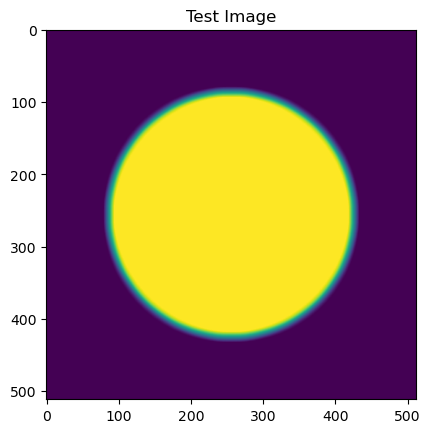

In [2]:
n = 512
# get complex test image
# test_image = get_test_image(n).astype(np.float32)

# get test image of a circle
test_image = np.zeros((n, n))
cv2.circle(test_image, center=(n//2, n//2), radius=n//3, color=(255,), thickness=-1)

# OPTIONAL blurr test image
cv2.GaussianBlur(test_image, ksize=(15,15), sigmaX=13, dst=test_image)

# 0-1 normalize
test_image = cv2.normalize(test_image, None, 0, 1, cv2.NORM_MINMAX, dtype=cv2.CV_32FC1)

plt.imshow(test_image) 
plt.title("Test Image");

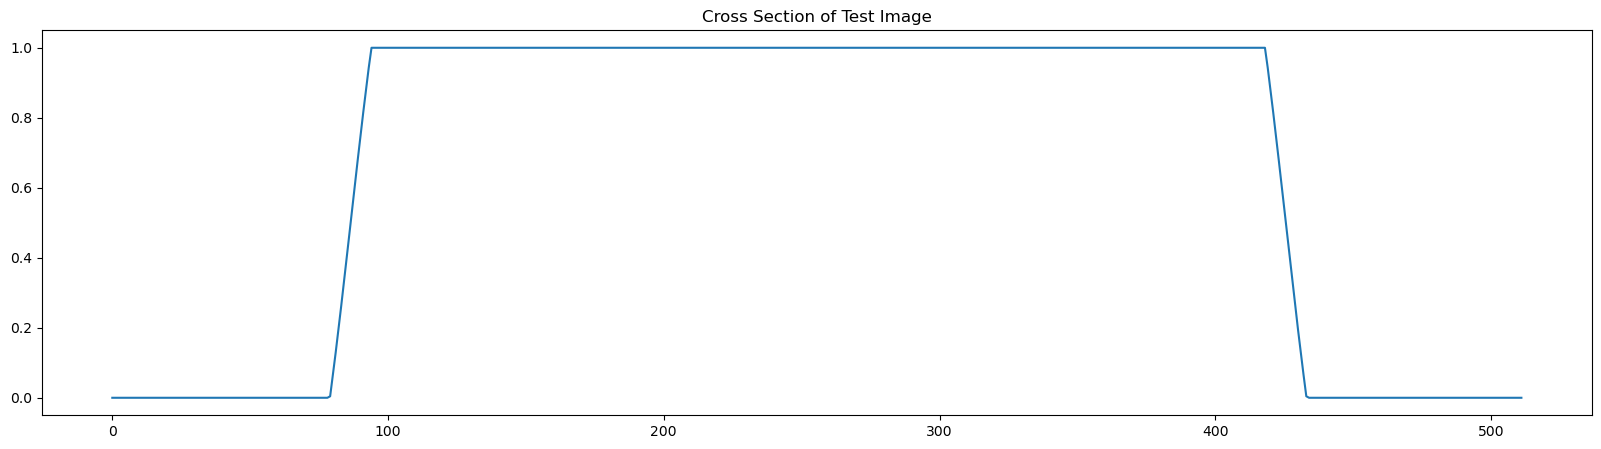

In [3]:
plt.figure(figsize=(20, 5))
plt.plot(test_image[256, :])
plt.title("Cross Section of Test Image");

## Sobel Filtering

In [39]:
Gx = np.array([[1, 0, -1],
               [2, 0, -2],
               [1, 0, -1]])
Gy = Gx.T

In [40]:
x_filtered = cv2.filter2D(test_image, ddepth=-1, kernel=Gx)
y_filtered = cv2.filter2D(test_image, ddepth=-1, kernel=Gy)

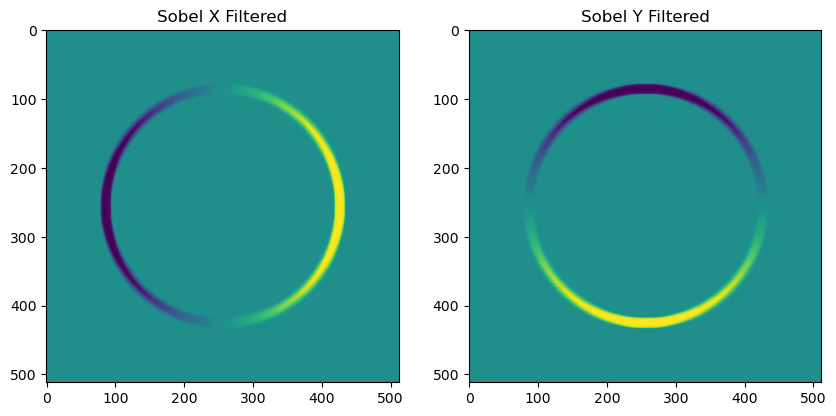

In [41]:
_, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(x_filtered)
ax[0].set_title("Sobel X Filtered")
ax[1].imshow(y_filtered)
ax[1].set_title("Sobel Y Filtered");

In [42]:
theta_deg = 45 # enter desired angle in degrees
theta = np.radians(theta_deg)

R_theta = np.cos(theta)*x_filtered + np.sin(theta)*y_filtered

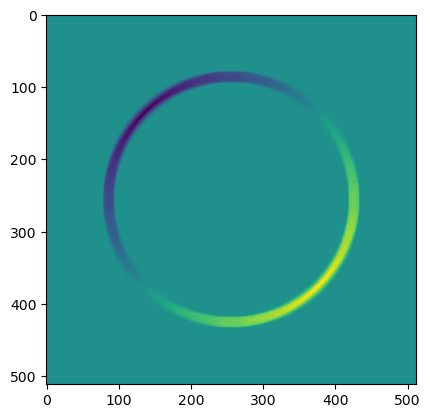

In [43]:
plt.imshow(R_theta);

In [44]:
G_theta = np.cos(theta)*Gx + np.sin(theta)*Gy

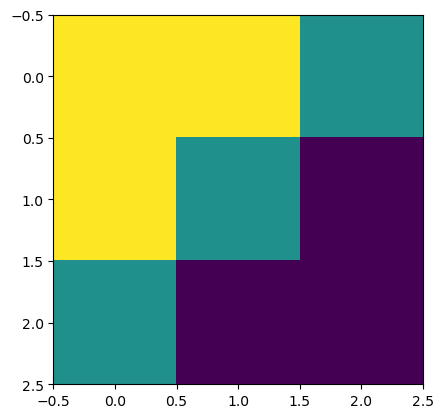

In [46]:
plt.imshow(G_theta);

In [48]:
R_theta = cv2.filter2D(test_image, ddepth=-1, kernel=G_theta)

In [ ]:
_, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(G_theta)
ax[0].set_title("45 dggree filter kernel")
ax[1].imshow(R_theta)
ax[1].set_title("45 degree filtered");

## Get Gaussian Filter Kernels

In [4]:
m = 4 # 1 sided filter size
x_index, y_index = np.meshgrid(np.arange(-m, m + 1), np.arange(-m, m + 1))
x_index = x_index.reshape((-1, 1))
y_index = y_index.reshape((-1, 1))

Get Kernel Functions

$$

\begin{align*}
    G &= e^{-(x^2 + y^2)} 
    \\
    G_1^{0\degree} &= \frac{\partial}{\partial x} e^{-(x^2 + y^2)} = -2x e^{-(x^2 + y^2)} 
    \\
    G_1^{90\degree} &= \frac{\partial}{\partial y} e^{-(x^2 + y^2)} = -2y e^{-(x^2 + y^2)} 
\end{align*}

$$

In [5]:
G = lambda x, y: np.exp(-(x**2 + y**2))
G0 = lambda x, y: -2*x*G(x,y)

# OPTIONAL: remove negative (to align mathematically) since vertical numers increase as we go down 
G90 = lambda x, y: 2*y*G(x,y) 

Get Kernels

In [6]:
# Gaussian Kernel
gk = G(x_index, y_index).reshape((m*2 + 1, m*2 + 1))

# Gaussian 1st Deriviative with 0 degree orientation
gk0 = G0(x_index, y_index).reshape((m*2 + 1, m*2 + 1))

# Gaussian 1st Deriviative with 90 degree orientation
gk90 = G90(x_index, y_index).reshape((m*2 + 1, m*2 + 1))

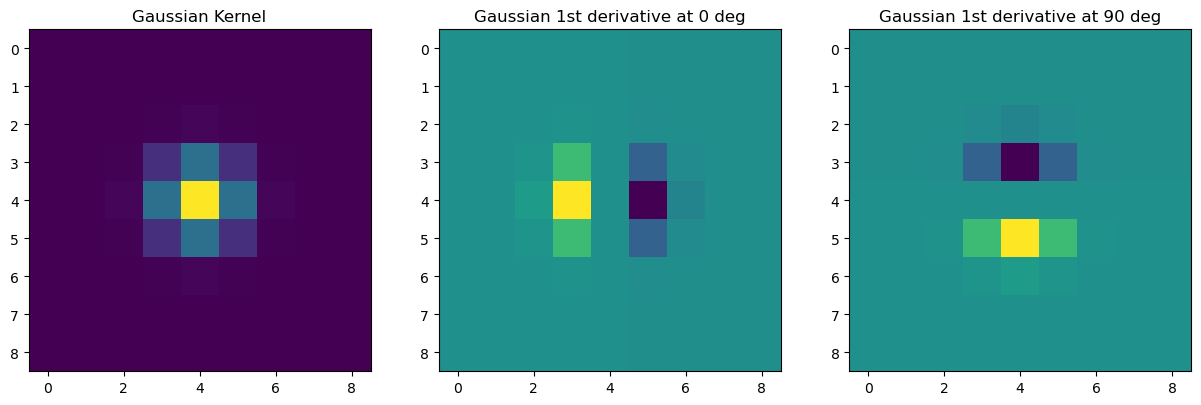

In [7]:
_, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(gk)
ax[0].set_title("Gaussian Kernel")
ax[1].imshow(gk0)
ax[1].set_title("Gaussian 1st derivative at 0 deg")
ax[2].imshow(gk90)
ax[2].set_title("Gaussian 1st derivative at 90 deg");

Apply Filters on test image

In [8]:
R = cv2.filter2D(test_image, ddepth=-1, kernel=gk)
R0 = cv2.filter2D(test_image, ddepth=-1, kernel=gk0)
R90 = cv2.filter2D(test_image, ddepth=-1, kernel=gk90)

Steer Filter with interpolation functions

$R_1^{0\degree}$ and $R_1^{90\degree}$ are deemed Basis Functions because they span the entire set of all possible $G_1^{\theta\degree}$. This means that we can take a linear combination of any $R_1^{0\degree}$ and $R_1^{90\degree}$ to create a new $G_1^{\theta\degree}$.

$$

\begin{align*}
    G_1^{\theta\degree} &= cos(\theta) R_1^{0\degree} + sin(\theta) R_1^{90\degree}
\end{align*}

$$

Where $cos(\theta)$ and $sin(\theta)$ are the interpolation functions becasuse they allow us to interpolate to a different angle given the basis functions $R_1^{0\degree}$ and $R_1^{90\degree}$. In this case interpolation is the same as steering, we are steering the filter to the orientation that we want using the interpolation function.

In [9]:
theta_deg = 45
theta = np.radians(theta_deg)

# steer filter
gk_theta = np.cos(theta)*gk0 + np.sin(theta)*gk90

# computer filtered image at new angle (two ways we can do this)

# linear combination of the 0 m and 90 degree filtered results
# R_theta = np.cos(theta)*R0 + np.sin(theta)*R90 

# Use Steered Filter
R_theta = cv2.filter2D(test_image, ddepth=-1, kernel=gk_theta) # might see slight roundoff errors

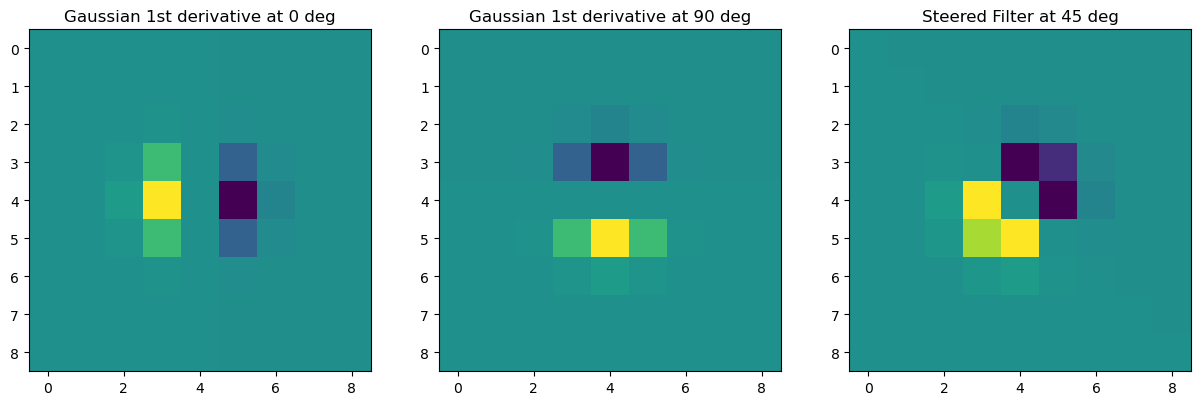

In [10]:
_, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(gk0)
ax[0].set_title("Gaussian 1st derivative at 0 deg")
ax[1].imshow(gk90)
ax[1].set_title("Gaussian 1st derivative at 90 deg");
ax[2].imshow(gk_theta)
ax[2].set_title(f"Steered Filter at {theta_deg} deg");

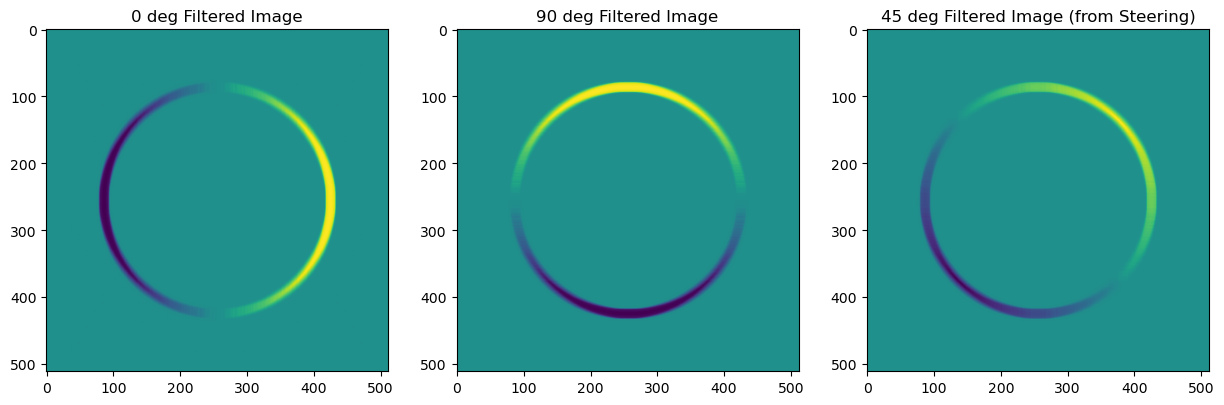

In [11]:
_, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(R0)
ax[0].set_title("0 deg Filtered Image")
ax[1].imshow(R90)
ax[1].set_title("90 deg Filtered Image")
ax[2].imshow(R_theta)
ax[2].set_title(f"{theta_deg} deg Filtered Image (from Steering)");

## Use a Bank of Steered Filters

Now we will pass a more interedting image through a bank of steered filteres

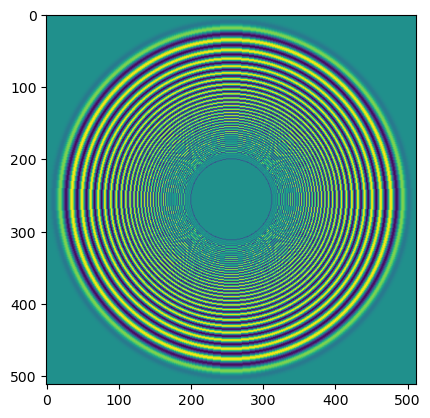

In [144]:
from skimage.data import camera

# test_image = camera()

# get complex test image
test_image = get_test_image(n).astype(np.float64)

# # blurr test image
# cv2.GaussianBlur(test_image, ksize=(7,7), sigmaX=7, dst=test_image)

# 0-1 normalize
test_image = cv2.normalize(test_image, None, 0, 1, cv2.NORM_MINMAX, dtype=cv2.CV_32FC1)

plt.imshow(test_image);

In [153]:
steering_angles = np.arange(0, 180, 10)

In [154]:
results = np.zeros((test_image.shape[0], test_image.shape[1], len(steering_angles)))
results.shape

(512, 512, 18)

In [155]:
# 0 degree filter
Rx = cv2.filter2D(test_image, ddepth=-1, kernel=gk0)

# 90 degree filter
Ry = cv2.filter2D(test_image, ddepth=-1, kernel=gk90)

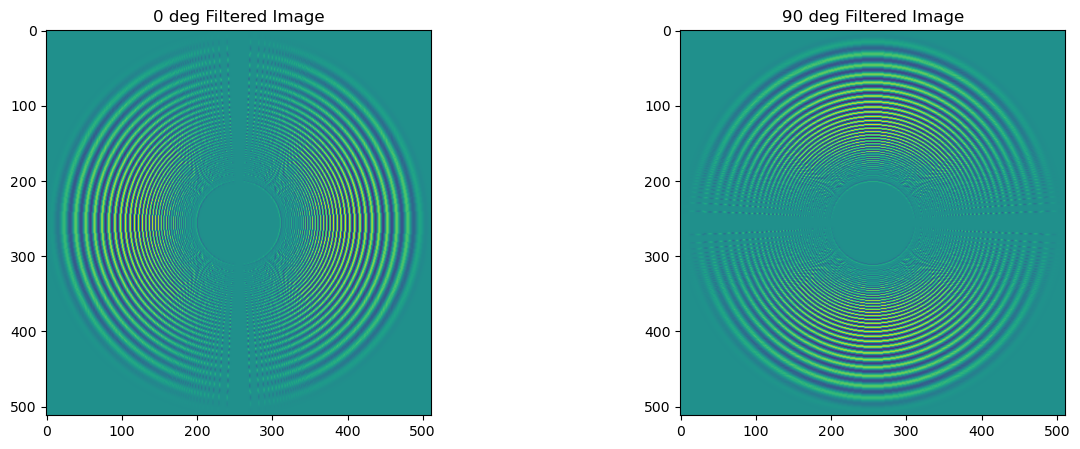

In [156]:
_, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].imshow(Rx)
ax[0].set_title("0 deg Filtered Image")
ax[1].imshow(Ry)
ax[1].set_title("90 deg Filtered Image");

In [161]:
# 0-1 normalize Rx
Rx_norm = cv2.normalize(Rx, None, 0, 1, cv2.NORM_MINMAX, dtype=cv2.CV_32FC1)

Ry_norm = cv2.normalize(Ry, None, 0, 1, cv2.NORM_MINMAX, dtype=cv2.CV_32FC1)

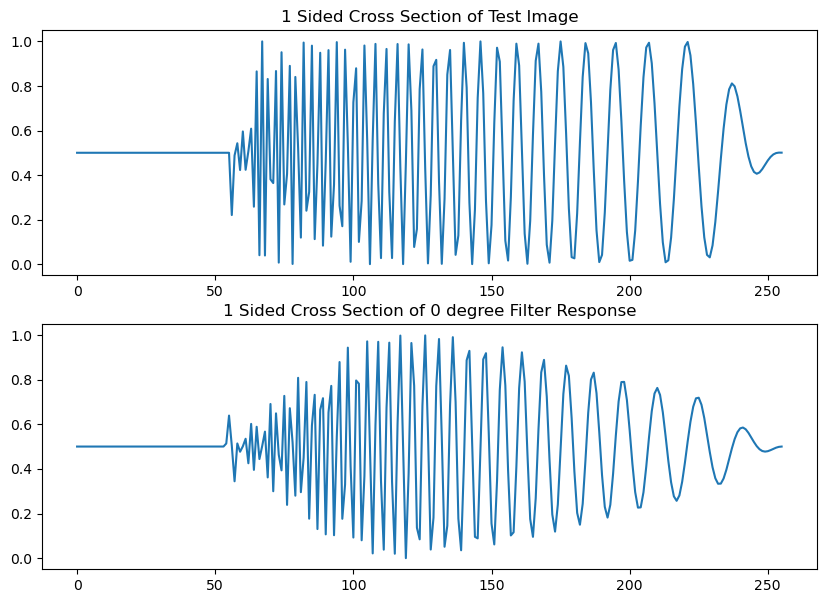

In [163]:
_, ax  = plt.subplots(2, 1, figsize=(10, 7))
ax[0].plot(test_image[256, 256:])
ax[0].set_title("1 Sided Cross Section of Test Image");
ax[1].plot(Rx_norm[256, 256:])
ax[1].set_title("1 Sided Cross Section of 0 degree Filter Response");

In [159]:
for i, angle in enumerate(steering_angles):
    theta = np.radians(angle)
    results[:, :, i] = np.cos(theta)*Rx + np.sin(theta)*Ry 

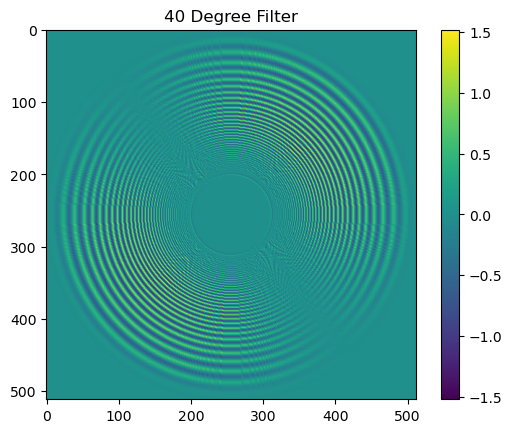

In [160]:
idx = 4

plt.imshow(results[:, :, idx])
plt.title(f"{steering_angles[idx]} Degree Filter");
plt.colorbar();

Now we can really see the value of this test image. In this image, we can actually see the Frequency Response for the Filters even though we are visualizing in the spatial domain. It is more responsive to middle frequencies and does not have a high response at the lower or higher frequencies